In [2]:
import numpy as np
import pandas as pd
from plotly import graph_objects as go, subplots as sp

from models import PoissonEM, PoissonGibbs

axis_col = 'rgba(0, 0, 0, 0.15)'
zero_col = 'rgba(0, 0, 0, 0.3)'
no_col = 'rgba(0, 0, 0, 0)'

xaxis_desc: dict = dict(linecolor=no_col, gridcolor=axis_col, zerolinecolor=zero_col, zerolinewidth=2)
yaxis_desc: dict = dict(linecolor=no_col, gridcolor=axis_col, zerolinecolor=zero_col, zerolinewidth=2)
layout = dict(
    autosize=True,
    width=1400,
    height=400,
    margin=dict(
        l=60, r=25, b=60, t=60, pad=5
    ),
    # paper_bgcolor="white",
    font_family="Times New Roman",
    font_color="black",
    font_size=20,
    plot_bgcolor='white',
    xaxis=dict(**xaxis_desc, ),
    yaxis=yaxis_desc,
)

from local.caching import load, save

# 1.2: implimentation

In [3]:
model = PoissonEM(
    alphas=[2, 2, 2],
    nu = 2, beta = 2,
    iterations=50,
    random_seed=0,
)

xs = pd.read_csv('pmm_q1.tsv', header=None).to_numpy()
model.Fit(xs)
print()
print(f"π: {model.pi}")
print(f"λ: {model.lambdas}")

50: log lik.: -2629.984 | delta: 0.000000         

π: [0.48641761 0.25031954 0.26326284]
λ: [ 0.73591369 12.48596296  5.61732164]


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


log liklihood + log prior vs iterations


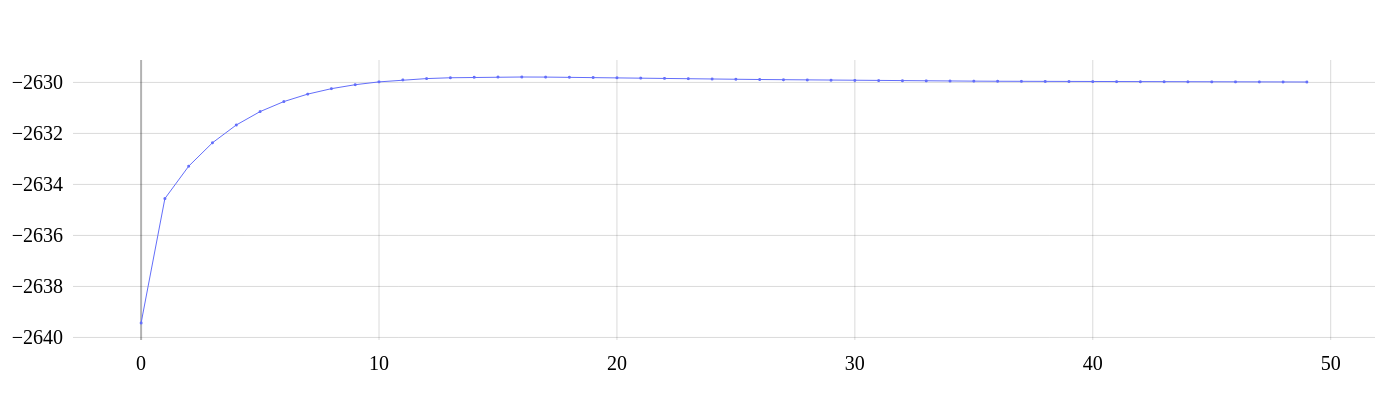

In [24]:
max_x = xs.max()
min_x = 0

fig = go.Figure()
cutt = None
fig.add_trace(
    go.Scatter(
        x = [x for x, y in enumerate(model.log_lls[:cutt])],
        y = [y for x, y in enumerate(model.log_lls[:cutt])],
        mode="lines+markers",
        marker=dict(size=3),
        line=dict(width=1),
        showlegend=False,
    ),
)

fig.update_annotations(font_size=24)
fig.update_layout(go.Layout(layout))

print("log liklihood + log prior vs iterations")
# fig.show()
from IPython.display import Image
Image(filename='q1_ll.png')

histogram and fitted densities


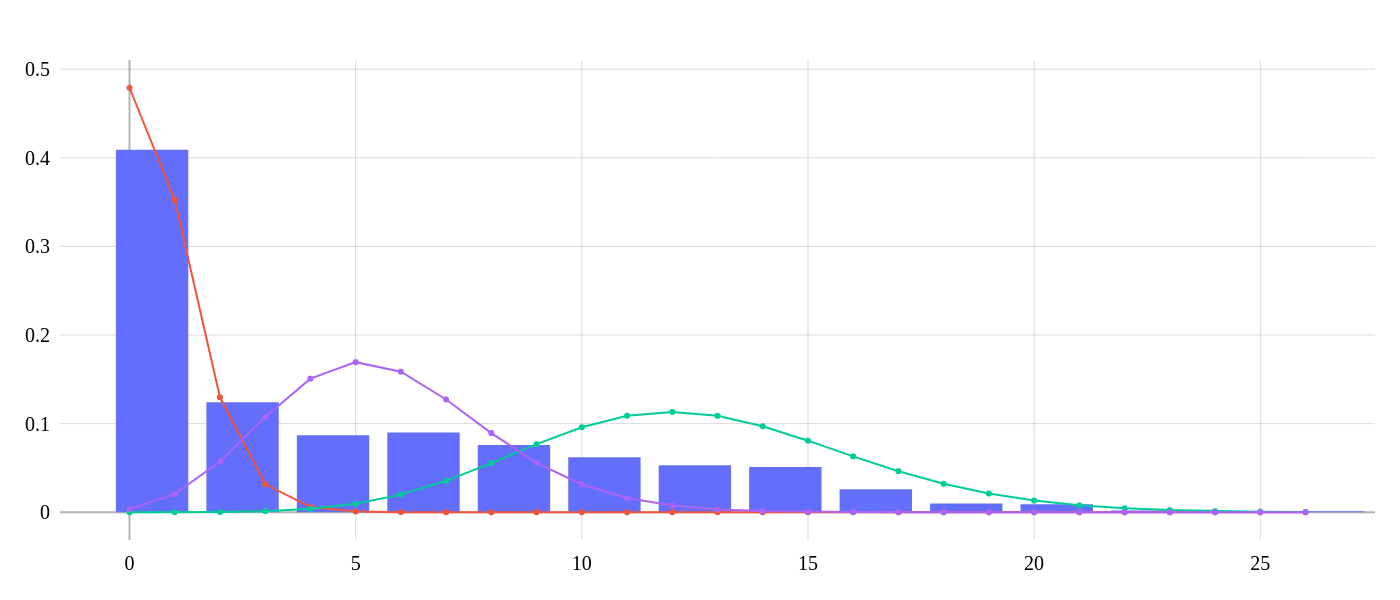

In [25]:
fig = go.Figure()

hist_xs = pd.read_csv('pmm_q1.tsv', header=None).to_numpy().T[0]
fig.add_trace(
    go.Histogram(
        x = hist_xs,
        histnorm='probability',
        nbinsx=len(set(hist_xs)),
        showlegend=False,
    )
)

import scipy
for lmd in model.lambdas.T:
    distr = [(x, scipy.stats.poisson.pmf(x, lmd)) for x in np.arange(min_x, max_x+1, 1)]
    fig.add_trace(
        go.Scatter(
            x = [x for x, y in distr],
            y = [y for x, y in distr],
            mode="lines+markers",
            showlegend=False,
        ),
    )

fig.update_annotations(font_size=24)
_layout = layout.copy()
_layout["height"] = 600
fig.update_layout(go.Layout(**_layout, 
    bargap=0.2,
))

print("histogram and fitted densities")

# fig.show()
from IPython.display import Image
Image(filename='q1_em_distr.png')

# 1.3: Gibbs sampling

In [22]:
iterations = 3000
retry = False
retry = True
modelg = PoissonGibbs(
    alphas=[2, 2, 2],
    nu = 2, beta = 5,
    iterations=iterations,
    random_seed=123,
)

save_file = f"gibbs_{iterations}"
previous = False
if not retry:
    try:
        modelg, pi, lambdas = load(save_file)
        previous = True
    except FileNotFoundError:
        pass

if not previous or retry:
    xs = pd.read_csv('pmm_q1.tsv', header=None).to_numpy()
    modelg.Fit(xs)

    pi, lambdas = modelg.pi, modelg.lambdas
    save(save_file, (modelg, pi, lambdas))
    
pi.shape, lambdas.shape

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


compressing & caching data to [{WORKSPACE}/hw/04/cache/gibbs_3000.pkl.gz]


((3001, 3), (3001, 3))

trace plot


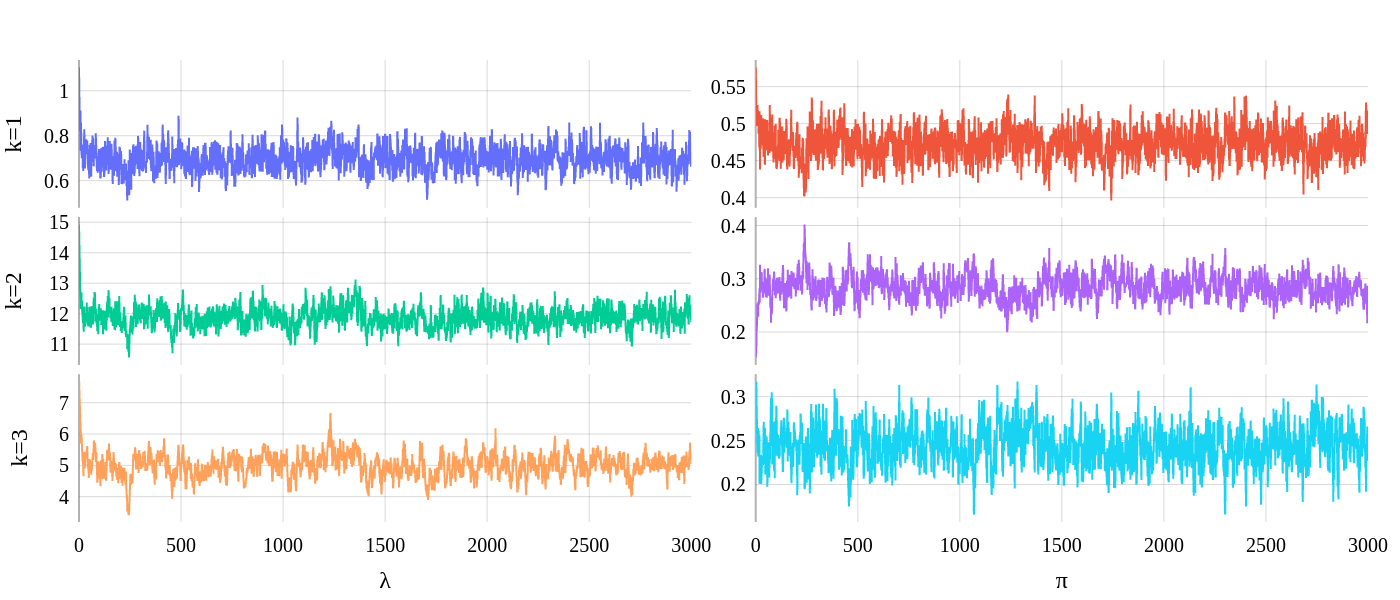

In [29]:
fig = sp.make_subplots(
    rows=3, cols=2, shared_xaxes=True, shared_yaxes=False, horizontal_spacing=0.05, vertical_spacing=0.02,
)
burn_in = 1000
for k in range(3):
    fig.add_trace(
        go.Scatter(
            x=[x for x, y in enumerate(lambdas[:, k])],
            y=[y for x, y in enumerate(lambdas[:, k])],
            mode="lines",
            showlegend=False,
        ),
        row=k+1, col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=[x for x, y in enumerate(pi[:, k])],
            y=[y for x, y in enumerate(pi[:, k])],
            mode="lines",
            showlegend=False,
        ),
        row=k+1, col=2,
    )

fig.update_annotations(font_size=24)
_layout = layout.copy()
_layout["height"] = 600
for i, xtitle, ytitle in zip(range(6), [""]*4+["λ", "π"], ["k=1", "", "k=2", "", "k=3", ""]):
    i += 1
    _layout[f"xaxis{i}"] = dict(title=xtitle, **xaxis_desc)
    _layout[f"yaxis{i}"] = dict(title=ytitle, **yaxis_desc)
fig.update_layout(go.Layout(_layout))

print("trace plot")

# fig.show()
from IPython.display import Image
Image(filename='q1_gibbs_trace.png')

running average


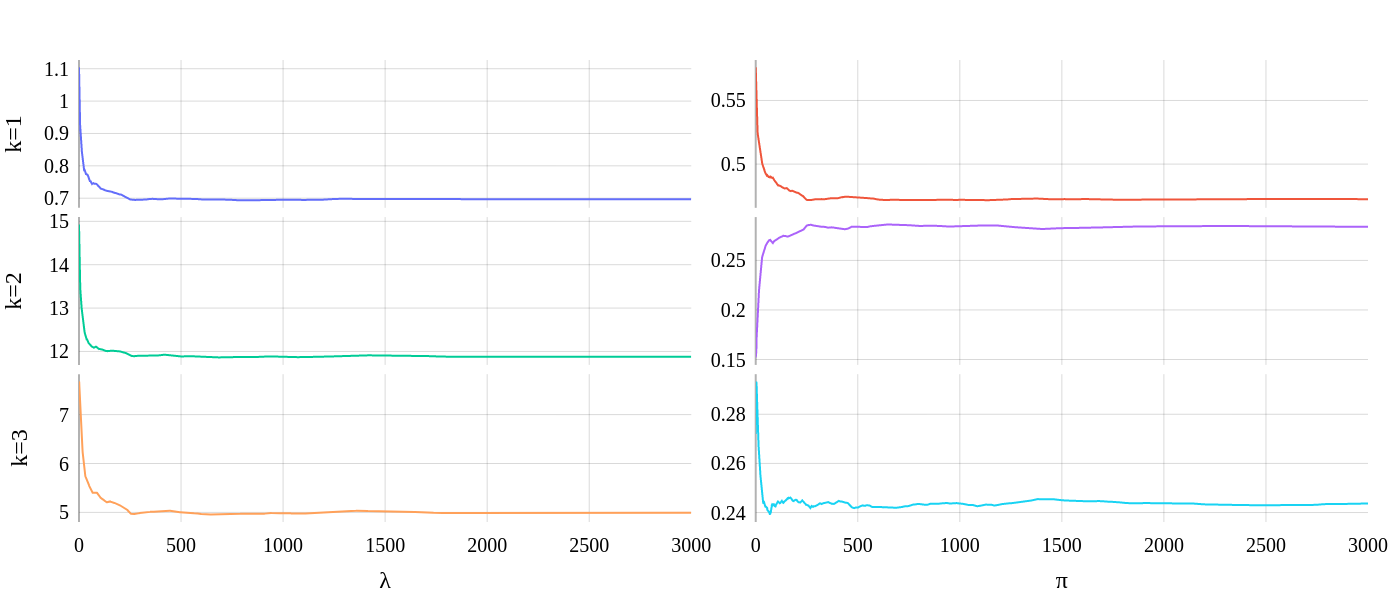

In [30]:
fig = sp.make_subplots(
    rows=3, cols=2, shared_xaxes=True, shared_yaxes=False, horizontal_spacing=0.05, vertical_spacing=0.02,
    # x_title = "Submission Date", y_title = "Assembly Counts",
)
def running_average(vec:np.ndarray):
    rav = np.zeros(shape=vec.shape)
    for i in range(len(vec)):
        rav[i] = vec[:i+1].sum()/(i+1)
    return rav

for k in range(3):
    ravl = running_average(lambdas[:, k])
    ravp = running_average(pi[:, k])
    fig.add_trace(
        go.Scatter(
            x=[x for x, y in enumerate(ravl)],
            y=[y for x, y in enumerate(ravl)],
            mode="lines",
            showlegend=False,
        ),
        row=k+1, col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=[x for x, y in enumerate(ravp)],
            y=[y for x, y in enumerate(ravp)],
            mode="lines",
            showlegend=False,
        ),
        row=k+1, col=2
    )

fig.update_annotations(font_size=24)
_layout = layout.copy()
_layout["height"] = 600
for i, xtitle, ytitle in zip(range(6), [""]*4+["λ", "π"], ["k=1", "", "k=2", "", "k=3", ""]):
    i += 1
    _layout[f"xaxis{i}"] = dict(title=xtitle, **xaxis_desc)
    _layout[f"yaxis{i}"] = dict(title=ytitle, **yaxis_desc)
fig.update_layout(go.Layout(_layout))

print("running average")
# fig.show()
from IPython.display import Image
Image(filename='q1_rav.png')

credible_intervals
λ1: 2.5%: 0.596448	50%: 0.696105	97.5%: 0.808844
λ2: 2.5%: 11.247277	50%: 11.869543	97.5%: 12.599940
λ3: 2.5%: 4.254761	50%: 4.998764	97.5%: 5.680461

π1: 2.5%: 0.433237	50%: 0.472986	97.5%: 0.512327
π2: 2.5%: 0.240803	50%: 0.282902	97.5%: 0.329956
π3: 2.5%: 0.200133	50%: 0.243753	97.5%: 0.288295



posterior distributions


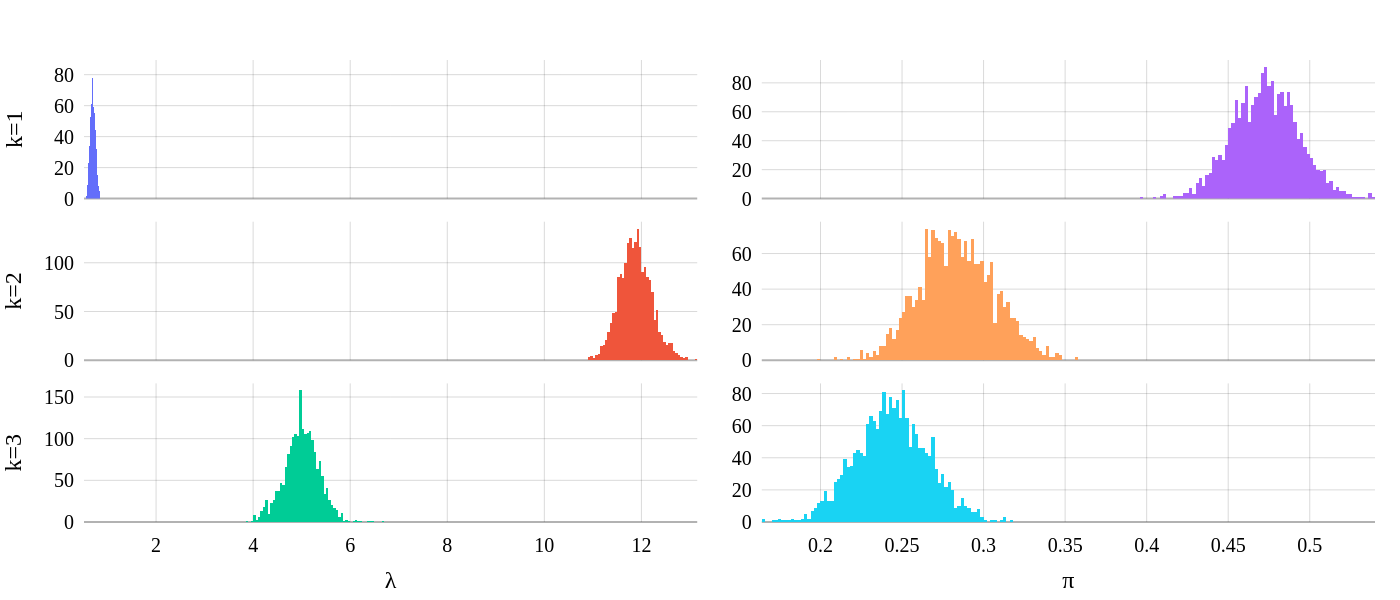

In [36]:
burn_in = 1000
fig = sp.make_subplots(
    rows=3, cols=2, shared_xaxes=True, shared_yaxes=False, horizontal_spacing=0.05, vertical_spacing=0.05,
)

print("credible_intervals")
def credible_interval(samples, name):
    lower, upper = 2.5, 97.5
    samples = sorted(samples)
    lr = int(round(len(samples)*lower/100))
    ur = int(round(len(samples)*upper/100))
    mr = int(round(len(samples)*0.5))
    print(*f"{name}: {lower}%: {samples[lr]:.6f}, 50%: {samples[mr]:.6f}, {upper}%: {samples[ur]:.6f}".split(', '), sep='\t')
fidelity:int = 20

K = 3
for k in range(K):
    samples_lmd = lambdas[burn_in:, k]
    ln = f"λ{k+1}"
    fig.add_trace(
        go.Histogram(
            x = samples_lmd,
            nbinsx=len(samples_lmd)//fidelity,
            showlegend=False,
        ),
        row=k+1, col=1,
    )
    credible_interval(samples_lmd, ln)

print()
for k in range(K):
    samples_pi = pi[burn_in:, k]
    pn = f"π{k+1}"
    fig.add_trace(
        go.Histogram(
            x = samples_pi,
            nbinsx=len(samples_pi)//fidelity,
            showlegend=False,
        ),
        row=k+1, col=2,
    )
    credible_interval(samples_pi, pn)

fig.update_annotations(font_size=24)
_layout = layout.copy()
_layout["height"] = 600
for i, xtitle, ytitle in zip(range(6), [""]*4+["λ", "π"], ["k=1", "", "k=2", "", "k=3", ""]):
    i += 1
    _layout[f"xaxis{i}"] = dict(title=xtitle, **xaxis_desc)
    _layout[f"yaxis{i}"] = dict(title=ytitle, **yaxis_desc)
fig.update_layout(go.Layout(_layout))

print("\n\n\nposterior distributions")
# fig.show()
Image(filename='q1_gibbs_posteriors.png')